Импортируем все необходимые библиотеки, в процессе будем подгружать еще)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

Ипортируем данные

In [5]:
df = pd.read_csv('/content/drive/MyDrive/pulsar_data_train.csv')
df.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


Для удобства работы переименовываем колонки и посмотрим сколько значений каждого класса

In [6]:
colu = ['mean_ip',
       'standard_ip',
       'excess_ip',
       'skewness_ip', 'mean_DM_SNR',
       'standard_DM_SNR',
       'exces_DM_SNR', 'skewness_DM_SNR',
       'target_class']
df.columns = colu
df['target_class'].value_counts()

0.0    11375
1.0     1153
Name: target_class, dtype: int64

Заполняем Nan средними значениями колонки

In [7]:
for col in df:
    col_median=df[col].median()
    df[col].fillna(col_median, inplace=True)


Разбиваем данные на тренировочный и тестовый сет. Смотрим размеры

In [8]:
X_train = np.array(df.drop('target_class', 1))
y_train = np.array(df['target_class'])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

print('X_train.shape', X_train.shape)
print('y_train.shape', y_train.shape)
print('X_test.shape', X_test.shape)

<ipython-input-8-11c8d200c8e6>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = np.array(df.drop('target_class', 1))


X_train.shape (10022, 8)
y_train.shape (10022,)
X_test.shape (2506, 8)


Стандартизируем значения для более точных результатов нашей сети

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

In [11]:
scaler.mean_

array([110.95976196,  46.53031477,   0.44081499,   1.7580647 ,
        12.59939529,  25.57452906,   8.32703603, 103.95353806])

Посмотрим на полученные значения

In [12]:
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = colu[:-1])
X_train_scaled.head()

,mean_ip,standard_ip,excess_ip,skewness_ip,mean_DM_SNR,standard_DM_SNR,exces_DM_SNR,skewness_DM_SNR
0,0.777427,1.252755,-0.384447,-0.363570,-0.253497,-0.124706,-0.547333,-0.603402
1,-0.006671,-0.042240,-0.291118,-0.282506,-0.388553,-0.796608,1.472948,1.830747
2,-3.901822,-1.302600,5.058185,4.416595,3.987484,2.057828,-1.846286,-1.011349
3,0.029053,1.212110,-0.221012,-0.365065,-0.339909,-0.305693,0.097618,-0.199844
4,-0.479634,-0.383466,-0.221012,-0.143660,-0.342408,-0.589745,0.055149,-0.031298


In [13]:
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = colu[:-1])
X_test_scaled.head()

,mean_ip,standard_ip,excess_ip,skewness_ip,mean_DM_SNR,standard_DM_SNR,exces_DM_SNR,skewness_DM_SNR
0,-0.292464,-0.054900,-0.132145,-0.185651,-0.362825,-0.593904,0.450960,0.247148
1,0.320647,0.384554,-0.403705,-0.342538,-0.332895,-0.342743,0.056415,-0.208907
2,-0.085448,0.412423,0.031667,-0.274524,-0.344736,-0.470153,0.260952,0.046600
3,0.352097,0.671555,-0.520177,-0.339816,0.346191,1.987646,-1.267223,-0.950953
4,0.849792,1.227248,-0.536916,-0.371473,-0.359304,-0.499634,0.603009,0.298874


Создаем сеть на 65 шагов

In [14]:
%%time

x0 = np.random.normal(size=(8, 2)) / np.sqrt(8)
neurons = torch.tensor(x0, requires_grad=True)


X = torch.tensor(X_train_scaled.values)
y = torch.tensor(y_train, dtype=torch.long)

optimizer = torch.optim.SGD(params=[neurons], lr=1)

loss_history = []


for i in range(65):

    predictions = X @ neurons

    loss = torch.nn.functional.cross_entropy(predictions, y)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    loss_history.append(loss.data.numpy())

CPU times: user 145 ms, sys: 8.12 ms, total: 153 ms
Wall time: 258 ms


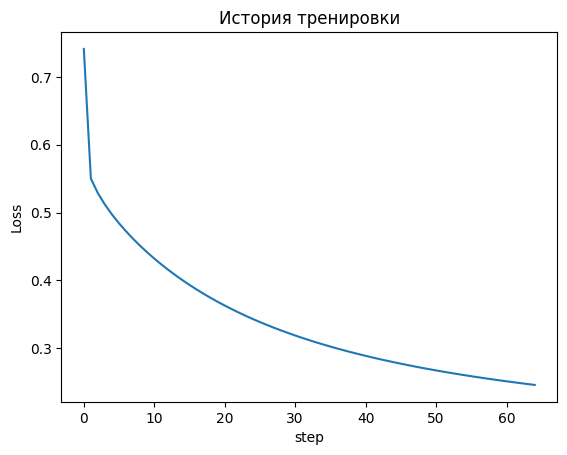

In [15]:
plt.title('История тренировки')
plt.ylabel('Loss')
plt.xlabel('step')
plt.plot(loss_history);

Время обучения - 258 мс и в процессе всего обучения loss падает, что свидетельствует об отсутсвии переобучения

Прогоняем через метрику и смотрим результат на тестовом сете

In [24]:
def sigmoid(x):
    ex = np.exp(x)
    return ex / (1 + ex)

digit_probabilities = sigmoid((X @ neurons).data.numpy())
print('digit_probabilities.shape:', digit_probabilities.shape)


from sklearn.metrics import f1_score


predictions = np.argmax(digit_probabilities, axis=1)
print('predictions.shape:', predictions.shape)
print('\nTrain f1:', f1_score(y_train, predictions, average='macro'))

digit_probabilities.shape: (10022, 2)
predictions.shape: (10022,)

Train f1: 0.8661435209563064


Пишем нейронную сеть на 200 нейронов и 2 слоя

In [25]:
import torch.nn.functional as F

class MyFirstNN(nn.Module):
    def __init__(self, n_hidden_neurons=200):
        super().__init__()
        # Здесь мы определяем обучаемые параметры модели
        # Первый слой весов
        # init_1 = np.random.normal(size=(784, n_hidden_neurons)) / np.sqrt(784) # гуглите "xavier initialization"
        # self.neurons_layer1 = torch.tensor(init_1, requires_grad=True) # веса для первого слоя нейронов
        # self.neurons_layer1 = nn.Parameter(self.neurons_layer1)
        self.neurons_layer1 = nn.Linear(8, n_hidden_neurons)

        # веса для второго слоя нейронов
        # init_2 = np.random.normal(size=(n_hidden_neurons, 10)) / np.sqrt(n_hidden_neurons)
        # self.neurons_layer2 = torch.tensor(init_2, requires_grad=True)
        # self.neurons_layer2 = nn.Parameter(self.neurons_layer2)
        self.neurons_layer2 = nn.Linear(n_hidden_neurons, 2)

    def forward(self, x):
        # Здесь мы делаем все вычисления
        # Первый слой
        # h = x @ self.neurons_layer1
        h = self.neurons_layer1(x)
        # Функция активации скрытого слоя
        # h = torch.relu(h)
        h = F.relu(h)

        # Выходной слой
        # out = h @ self.neurons_layer2
        out = self.neurons_layer2(h)
        return out

Накапливаем импульс во время спуска

In [27]:
import numpy as np

model = MyFirstNN()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [28]:
from tqdm import tqdm

N_EPOCHS = 50

# Конвертируем в торч тензор
X_tr = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_tr = torch.tensor(y_train, dtype=torch.long)
X_dev = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_dev = torch.tensor(y_test, dtype=torch.long)

train_loss_history = []
dev_loss_history = []

# Пройдемся 50 эпох
for i in tqdm(range(N_EPOCHS)):
    # Прямой проход (предсказания)
    predictions = model(X_tr)
    # Функция потерь
    loss = torch.nn.functional.cross_entropy(predictions, y_tr) # активация уже включена
    # Градиенты
    optimizer.zero_grad()
    loss.backward()
    # Шаг спуска
    optimizer.step()
    train_loss_history.append(loss.item())

    # Валидируемся
    if i % 10 == 0:
        predictions = model(X_dev)
        loss = torch.nn.functional.cross_entropy(predictions, y_dev)
        dev_loss_history.append(loss.item())

100%|██████████| 50/50 [00:00<00:00, 51.58it/s]


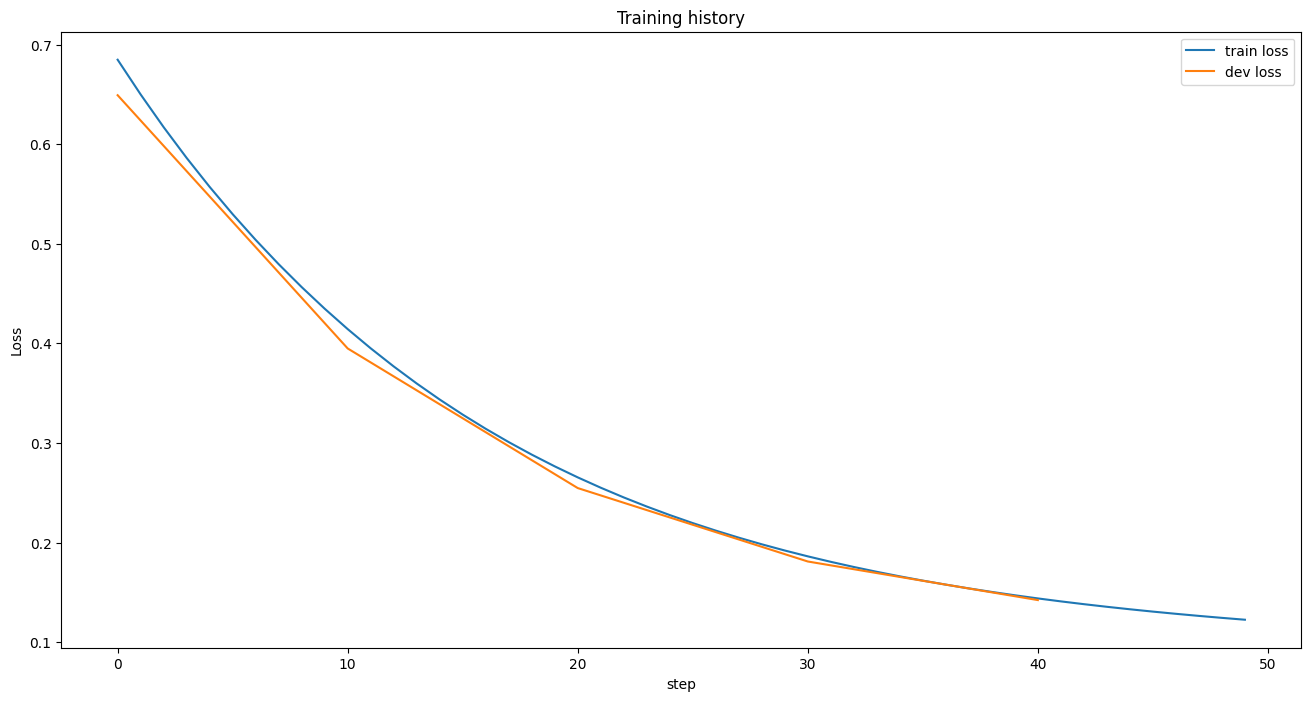

In [29]:
plt.figure(figsize=(16, 8))
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('step')
plt.plot(range(N_EPOCHS), train_loss_history, label='train loss')
plt.plot(range(N_EPOCHS)[::10], dev_loss_history, label='dev loss')
plt.legend();

Видно, что модель не переобучается, и на тестовых данных работает практически аналогично тренировочным

In [30]:
# Метрики качества
digit_probabilities = model(X_dev).detach().numpy()
print('digit_probabilities.shape:', digit_probabilities.shape)
# Нашли вероятности принадлежности семплов test-а

from sklearn.metrics import classification_report

# Округлили
predictions = np.argmax(digit_probabilities, axis=1)
print('predictions.shape:', predictions.shape)
print('test results:')
print(classification_report(y_dev.detach().cpu().numpy(), predictions))

digit_probabilities.shape: (2506, 2)
predictions.shape: (2506,)
test results:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2267
           1       0.96      0.73      0.83       239

    accuracy                           0.97      2506
   macro avg       0.97      0.86      0.91      2506
weighted avg       0.97      0.97      0.97      2506



Создаем вторую нейронную сеть, 200 нейронов, 4 слоя

In [31]:
from torch.nn import ReLU
import torch.nn.functional as F

class MySecondNN(nn.Module):
    def __init__(self, n_hidden_neurons=200):
        # super позволяеть наследовать методы модуля nn
        super(MySecondNN,self).__init__()
        # создаем линейный слой
        self.linear1 = nn.Linear(8,2)
        self.linear2 = nn.Linear(2,n_hidden_neurons)
        self.linear3 = nn.Linear(n_hidden_neurons,n_hidden_neurons)
        self.linear4 = nn.Linear(n_hidden_neurons,2)
        self.ReLU = nn.ReLU(inplace=True)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

import numpy as np

model = MySecondNN()
# инициализируем Adam для накопления импульса во время спуска
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [32]:
N_EPOCHS = 100

# Конвертируем в торч тензор
X_tr = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_tr = torch.tensor(y_train, dtype=torch.long)
X_dev = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_dev = torch.tensor(y_test, dtype=torch.long)

train_loss_history = []
dev_loss_history = []
ce = nn.CrossEntropyLoss()

# Пройдемся 501 эпоху
for i in tqdm(range(N_EPOCHS)):
    # Прямой проход (предсказания)
    predictions = model(X_tr)
    # Функция потерь
    loss = ce(predictions, y_tr) # активация уже включена
    # Градиенты
    optimizer.zero_grad()
    loss.backward()
    # Шаг спуска
    optimizer.step()
    train_loss_history.append(loss.item())

    if i % 10 == 0:
       predictions = model(X_dev)
       loss = ce(predictions, y_dev)
       dev_loss_history.append(loss.item())

100%|██████████| 100/100 [00:06<00:00, 15.98it/s]


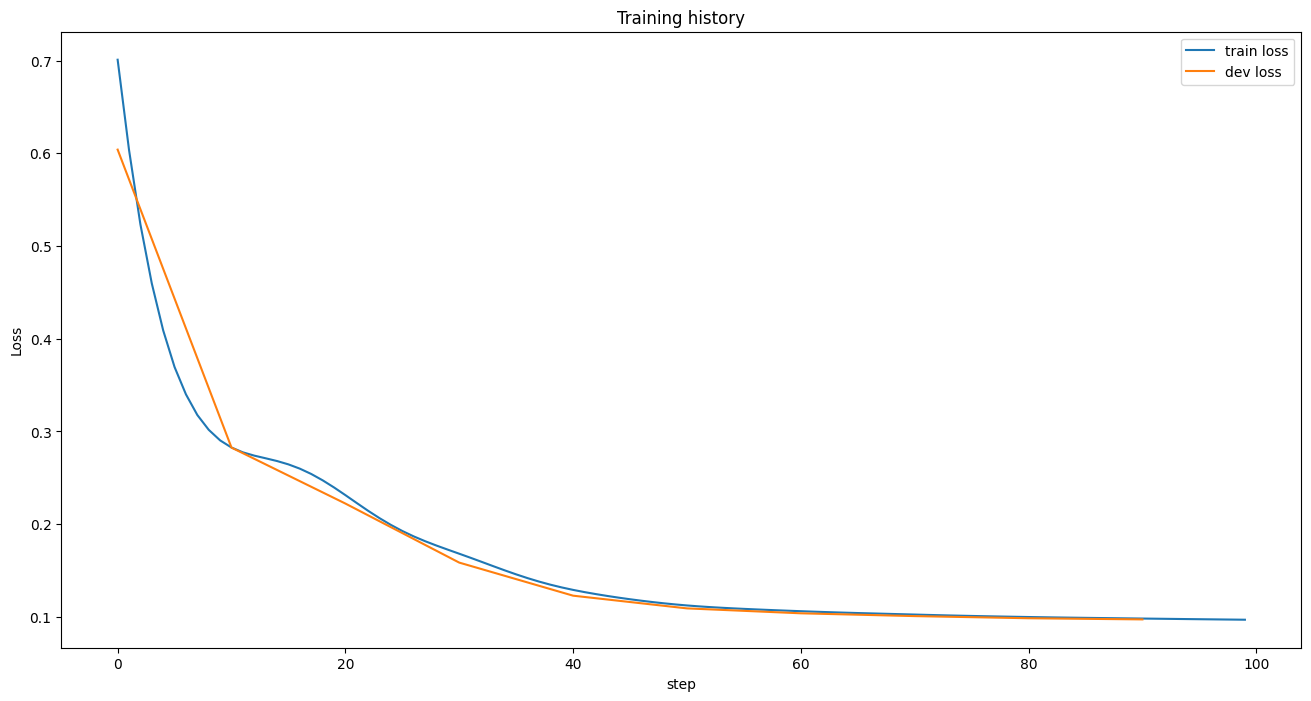

In [33]:
plt.figure(figsize=(16, 8))
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('step')
plt.plot(range(N_EPOCHS), train_loss_history, label='train loss')
plt.plot(range(N_EPOCHS)[::10], dev_loss_history, label='dev loss')
plt.legend();

Стремительное обучение идет до 40ой эпохи, тестовый сет идет синхронно с тренировочным. Переобучения не наблюдается

In [34]:
digit_probabilities = model(X_dev).detach().numpy()
print('digit_probabilities.shape:', digit_probabilities.shape)

from sklearn.metrics import classification_report

predictions = np.argmax(digit_probabilities, axis=1)
print('predictions.shape:', predictions.shape)
print('test results:')
print(classification_report(y_dev.detach().cpu().numpy(), predictions))

digit_probabilities.shape: (2506, 2)
predictions.shape: (2506,)
test results:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2267
           1       0.94      0.80      0.86       239

    accuracy                           0.98      2506
   macro avg       0.96      0.90      0.92      2506
weighted avg       0.98      0.98      0.97      2506



Создаем третью нейросеть.

In [66]:
X_tr = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_tr = torch.tensor(y_train, dtype=torch.long)
X_dev = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_dev = torch.tensor(y_test, dtype=torch.long)

In [67]:
X_dev.shape, y_dev.shape

(torch.Size([2506, 8]), torch.Size([2506]))

In [137]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

In [144]:
def train(net, n_epoch=5, batch_size=32):

    loss_fn = nn.CrossEntropyLoss()
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    best_accuracy = 0

    train_dataset = TensorDataset(X_tr, y_tr)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(n_epoch):

        running_loss = 0.0

        for i, batch in enumerate(train_loader):

            X_batch, y_batch = batch

            optimizer.zero_grad()

            y_pred = net(X_batch)

            loss = loss_fn(y_pred, y_batch)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0


        with torch.no_grad():
            net.eval()
            accuracy = []
            for i in range(len(X_dev)):
                x, y = X_dev[i], y_dev[i]

                y_pred = net(x)

                _, y_pred_class = torch.max(y_pred, 0)

                y_batch_np = y.item()
                y_pred_class_np = y_pred_class.item()

                accuracy.append(accuracy_score([y_batch_np], [y_pred_class_np]))

                # y_pred = torch.sigmoid(y_pred).detach().numpy()
                # y_pred_class = (y_pred >= 0.5).astype(int)


                # accuracy.append(accuracy_score([y.numpy()], [y_pred_class]))

            accuracy_1 = np.mean(np.array(accuracy))

            if accuracy_1 > best_accuracy:
                print('New best model with test acc:', accuracy_1)
                torch.save(net.state_dict(), './best_model.pt')
                best_accuracy = accuracy_1

            net.train()

    print('Обучение закончено')
    return net

In [145]:
model = nn.Sequential(
    nn.Linear(8, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 2)
)

In [146]:
model = train(model)

[1,   100] loss: 0.196
[1,   200] loss: 0.104
[1,   300] loss: 0.069
New best model with test acc: 0.9804469273743017
[2,   100] loss: 0.070
[2,   200] loss: 0.068
[2,   300] loss: 0.088
[3,   100] loss: 0.065
[3,   200] loss: 0.071
[3,   300] loss: 0.086
[4,   100] loss: 0.073
[4,   200] loss: 0.078
[4,   300] loss: 0.072
[5,   100] loss: 0.072
[5,   200] loss: 0.075
[5,   300] loss: 0.064
Обучение закончено


In [147]:
digit_probabilities = model(X_dev).detach().numpy()

print('digit_probabilities.shape:', digit_probabilities.shape)


predictions = np.argmax(digit_probabilities, axis=1)
print('predictions.shape:', predictions.shape)


print('test results:')
print(classification_report(y_dev.numpy(), predictions))

digit_probabilities.shape: (2506, 2)
predictions.shape: (2506,)
test results:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2267
           1       0.96      0.82      0.88       239

    accuracy                           0.98      2506
   macro avg       0.97      0.91      0.94      2506
weighted avg       0.98      0.98      0.98      2506



Получилась отличная(но не идеальная) нейросеть бинарной классификации, которая улавливает с 98% точностью класс "0" и 96% класс "1". F1-мера для класса "1" составляет 0.88, что говорит о том, что качество предсказаний для класса "1" немного ниже, чем для класса "0". Но это терпимо. Честно говоря, было сложно достичь даже таких результатов, так что я безумно рада, что recall вообще больше 0,5.
